In [14]:
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
import xlrd
from datetime import datetime
import os

In [9]:
def CompareWaterTable(path_model_outputs, path_observed_data, Inputs_file_modflow, res_ModFlow):
    """ Compare simulated and observed water table and water table depth,
    return different criteria and plot results,
    assuming that Groundwater nc files from CWatM-ModFlow are at daily timestep and
    from the end of initialization to the last modeled day"""
      
    ## Loading files containing basin grid information
    Size = np.loadtxt(Inputs_file_modflow + 'UB_limits.txt')
    res_ModFlow = (Size[1]-Size[0])/(Size[5]-1)  # in [m]
    print('ModFlow resolution is : ', res_ModFlow, ' meters')
    basin = np.loadtxt(Inputs_file_modflow + 'Basin_limits.txt')

    # Map dimensions
    ncol = int((Size[1]-Size[0])/res_ModFlow)+1 
    nrow = int(abs((Size[3]-Size[2])/res_ModFlow)+1)
    basin = basin.reshape(nrow,ncol)              # ModFlow format
    
    ## UPLOAD SIMULATED WATER TABLE AND TOPOGRAPHY ##
    
    # Water table
    ds = xr.open_dataset(path_model_outputs + '/' + 'modflowWaterLevel_monthend.nc')         # Coord System: epsg 4326
    #ds = xr.open_dataset(Water_Table_file)
    GWTable_ModFlow = ds['modflowWaterLevel_monthend'][:].data                               # Matrix of water levels [m/day] (time, nrow, ncol)
    Time_ModFlow = ds['time'][:].data
    Time_ModFlowV2 = (Time_ModFlow - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    Time_ModFlowV3 = np.zeros(len(Time_ModFlow))
    for it in range(len(Time_ModFlow)):
        dd = datetime.utcfromtimestamp(Time_ModFlowV2[it])
        Time_ModFlowV3[it] = dd.toordinal()
    ds.close()

    
    # Topography
    # Warning soil thickness could be different for each model!! REPLACE OBSERVED DATA BY OUTPUT FOLDER
    ds = xr.open_dataset(path_observed_data + 'modflowtotalSoilThickness_totalend.nc')
    Soil_thickness = ds['modflowtotalSoilThickness_totalend'][:].data 
    ds.close()
    Top = np.loadtxt(Inputs_file_modflow + 'Topo.txt')
    Topography_ModFlow = Top.reshape(nrow,ncol) + Soil_thickness # We need to add soil thickness to compare WTD
    
    
    ## UPLOAD OBSERVED WATER TABLE AND FIND THE MODFLOW COORDINATES OF EACH BOREHOLE ##
    ## IMPORTING MEASURED WATER TABLE DEPTH AND CREATING ARRAYS
    
    Measured_watertabledepth = np.zeros((382,21)) # 2D array containing measured data: 382 boreholes for Bhima, 21 dates
    wb = xlrd.open_workbook(path_observed_data+ "UB_GW_DataProcessed.xls")
    sh = wb.sheet_by_name(u'Sheet1')
    for il in range(np.shape(Measured_watertabledepth)[0]):
        for ic in range(np.shape(Measured_watertabledepth)[1]):
            val=sh.row_values(il+1)[ic]
            if val == '':
                Measured_watertabledepth[il][ic] = np.nan
            else:
                Measured_watertabledepth[il][ic] = val
    
    # Associated date
    Measured_dates = np.zeros(np.shape(Measured_watertabledepth)[1])
    for ic in range(np.shape(Measured_watertabledepth)[1]):
        # dd = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(sh.row_values(0)[0]) - 2).strftime('%Y%m%d')
        Measured_dates[ic] = datetime(1900, 1, 1).toordinal() + int(sh.row_values(0)[ic]) - 2
    
    
    # Upload coordinates, water table and topography of each borehole
    x_GW = np.loadtxt(path_observed_data + 'GW_level_x.txt')
    y_GW = np.loadtxt(path_observed_data + 'GW_level_y.txt')
    z_GW = np.loadtxt(path_observed_data + 'GW_level_z.txt')
    
    # List containing only boreholes in the basin and not too close from the basin limit (at least 1 cell)
    x_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])   # Boreholes out of the basin will be removed after            
    y_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0]) 
    z_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])
    wt_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))                 # Observed water table
    wtd_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))                # Observed water table depth
    Sim_wtd_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))            # Simulated water table
    Sim_wt_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))             # Simulated water table depth
    Sim_z_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])              # Altitude of the cell in the model (differnt from borehole information)
    
    # To do a linear interpolation inside the grid
    X = np.arange(0, ncol)
    Y = np.arange(0, nrow)
    X,Y = np.meshgrid(X,Y)
    points = np.array( (X.flatten(), Y.flatten()) ).T
    
    # We assume the period April 1997 to April 2007 is included in the model
    # We look for 31 March 1997 in the simulated data
    # WE HAVE TO LOOK FOR EACH INDEX!
    Index_measured_date = np.zeros(len(Measured_dates))
    for it in range(len(Measured_dates)):
        Index_measured_date[it] = np.argmin(np.abs(Time_ModFlowV3-Measured_dates[it]))
       
    valuesWaterTable = np.zeros((np.shape(Measured_watertabledepth)[1], nrow*ncol))
    valuesWaterTableDepth = np.zeros((np.shape(Measured_watertabledepth)[1], nrow*ncol))
    
    for it in range(len(Measured_dates)): # For each measured time
        PiezoMap = GWTable_ModFlow[int(Index_measured_date[it])]
        PiezoDepthMap = Topography_ModFlow - GWTable_ModFlow[int(Index_measured_date[it])]
        valuesWaterTable[it] = PiezoMap.flatten()             # Map of the simulated water table for each date of observation
        valuesWaterTableDepth[it] = PiezoDepthMap.flatten()   # Map of the simulated water table depth for each date of observation
    
    valuesTopography_ModFlow = Topography_ModFlow.flatten()   # Map of the topography defined in ModFlow
    
    som=0
    for pz in range(len(x_GW)): # For each monitoring borehole
        
        # Find the corresponding column and row where the borehole is located
        colPz = int(round((x_GW[pz]-float(Size[0]))/res_ModFlow))
        rowPz = int(round((float(Size[2])-y_GW[pz])/res_ModFlow))
        
        if colPz>0 and rowPz>0 and colPz<ncol and rowPz<nrow:       # If the borehole is in the model
            if basin[rowPz][colPz] == 1:         # If the borehole is in the basin
                
                # Interpolating the simulated value as observation points are not in the cells center
                X0 = (x_GW[pz]-float(Size[0]))/res_ModFlow
                Y0 = (float(Size[2])-y_GW[pz])/res_ModFlow
                
                close_points = points[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 6] # all points at distance < 4 cell units
                # If the cell is not too close from an inactive cell (= too close from the basin limits)

                if 0 not in basin[close_points[:,1],close_points[:,0]]:
                    som=som+1
                    
                    x_GW_bhima[som-1] = x_GW[pz]
                    y_GW_bhima[som-1] = y_GW[pz]
                    z_GW_bhima[som-1] = z_GW[pz]
                    wtd_GW_bhima[som-1][:] = Measured_watertabledepth[pz]               # Each column corresponds to a specific date between April 1997 and April 2007
                    wt_GW_bhima[som-1][:] = z_GW[pz]-Measured_watertabledepth[pz]
    
                    ## As interpolation seems to long for the Bhima, we create a new grid closer from the point
                    points2 = points[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                    
                    valuesTopography_ModFlow2 = valuesTopography_ModFlow[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                    Val = griddata(points2, valuesTopography_ModFlow2, (X0,Y0), method='linear' )
                    Sim_z_GW_bhima[som-1] = Val
                    
                    compt=0
                    for ii in range(len(Measured_dates)): # For each measured time
    
                        valuesWaterTableDepth2 = valuesWaterTableDepth[ii][np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                        valuesWaterTable2 = valuesWaterTable[ii][np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                        Val = griddata(points2, valuesWaterTableDepth2, (X0,Y0), method='linear' )
                        Sim_wtd_GW_bhima[som-1][compt] = Val
                        Val = griddata(points2, valuesWaterTable2, (X0,Y0), method='linear' )
                        Sim_wt_GW_bhima[som-1][compt] = Val
                        compt+=1
    
#    print('Number of boreholes in the Bhima basin : ', np.shape(Measured_watertabledepth)[0])            
#    print('Number of boreholes used for water table comparison : ', som)
    
    # Keep only boreholes inside the basin and not too close from the basin limits
    x_GW_bhima = x_GW_bhima[:som]       
    y_GW_bhima = y_GW_bhima[:som] 
    z_GW_bhima = z_GW_bhima[:som] 
    wt_GW_bhima = wt_GW_bhima[:som] 
    wtd_GW_bhima = wtd_GW_bhima[:som] 
    Sim_wtd_GW_bhima = Sim_wtd_GW_bhima[:som] 
    Sim_wt_GW_bhima = Sim_wt_GW_bhima[:som] 
    Sim_z_GW_bhima = Sim_z_GW_bhima[:som] 
       
    
    ## COMPUTING ROOT MEAN SQUARE ERROR AND CORELATION BETWEEN OBSERVATION AND SIMULATION ##
    ## MEAN VALUE ## -> compute a global RMS error, normalized difference,
    ## normalized RMSE and coefficient of correlation
    
    ## Time averaging of simulate and observed data
    Mean_Sim_wt_GW_bhima = np.mean(Sim_wt_GW_bhima,1)
    Mean_Sim_wtd_GW_bhima = np.mean(Sim_wtd_GW_bhima,1)
    Mean_wt_GW_bhima = np.nanmean(wt_GW_bhima,1)    # nanmean is used because there are nan values in observed data
    Mean_wtd_GW_bhima = np.nanmean(wtd_GW_bhima,1)
    
    ## Correlation COEFFICIENT
    PearsonWaterTable = np.corrcoef(Mean_wt_GW_bhima, Mean_Sim_wt_GW_bhima)    
    CorrWaterTable = PearsonWaterTable[0][1]
    PearsonWaterTableDepth = np.corrcoef(Mean_wtd_GW_bhima, Mean_Sim_wtd_GW_bhima)    
    CorrWaterTableDepth = PearsonWaterTableDepth[0][1]
    
    ## MEAN Normalize water table depth difference
    average_Norm_diffDepth = np.nanmean(np.abs(Mean_wtd_GW_bhima - Mean_Sim_wtd_GW_bhima)/Mean_wtd_GW_bhima*100) # In percentage
    Norm_diffDepth = (Mean_wtd_GW_bhima - Mean_Sim_wtd_GW_bhima)/Mean_wtd_GW_bhima*100 # In percentage
    # The 'average' criteria is always positive, we add - to indicate if simulated water levels are too deep
    average_Norm_diffDepth = average_Norm_diffDepth * (np.nanmean(Norm_diffDepth)/np.abs(np.nanmean(Norm_diffDepth)))
    
    ## MEAN Root mean square error
    RmseWaterTable = np.sqrt(np.sum((Mean_wt_GW_bhima - Mean_Sim_wt_GW_bhima)**2) / len(Mean_wt_GW_bhima))
    RmseWaterTableDepth = np.sqrt(np.sum((Mean_wtd_GW_bhima - Mean_Sim_wtd_GW_bhima)**2) / len(Mean_wtd_GW_bhima))

    ## MEAN normalized Root mean square error
    RmseWaterTable_norm = RmseWaterTable/np.std(Mean_wt_GW_bhima)
    RmseWaterTableDepth_norm = RmseWaterTableDepth/np.std(Mean_wtd_GW_bhima)
      
        
    ## COMPUTING ROOT MEAN SQUARE ERROR AND CORELATION BETWEEN OBSERVATION AND SIMULATION ##
    ## TRANSIENT VALUE ## -> compute nRMSE for each borehole, after subtracting the mean as the mean behavior is already compared by other criteria

    ## Computing normalized root mean square error on water table fluctuations for each borehole
    Transient_nRMSE = np.zeros(len(wt_GW_bhima))
    for ib in range(len(wt_GW_bhima)): # For each borehole
        Transient_nRMSE[ib] = np.sqrt(np.nansum((wt_GW_bhima[ib]-np.nanmean(wt_GW_bhima[ib])-(Sim_wt_GW_bhima[ib]-np.nanmean(Sim_wt_GW_bhima[ib])))**2) / np.count_nonzero(~np.isnan(wt_GW_bhima[ib]))) / np.nanstd(wt_GW_bhima[ib])
    
    ## Mean value of the nRMSE in transient
    wt_fluctu = np.zeros((len(wt_GW_bhima),len(Measured_dates)))
    Sim_wt_fluctu = np.zeros((len(wt_GW_bhima),len(Measured_dates)))
    for ib in range(len(wt_GW_bhima)): # for each borehole, remove the mean
        wt_fluctu[ib] = wt_GW_bhima[ib]-np.nanmean(wt_GW_bhima[ib])
        Sim_wt_fluctu[ib] = Sim_wt_GW_bhima[ib]-np.nanmean(Sim_wt_GW_bhima[ib])

    Average_transient_nRMSE = np.sqrt(np.nansum((np.nanmean(wt_fluctu, 0)-np.nanmean(Sim_wt_fluctu, 0))**2) / np.count_nonzero(~np.isnan(np.nanmean(wt_fluctu, 0)))) / np.nanstd(np.nanmean(wt_fluctu, 0))

    # Optimize curve fitting with a sinus, to compare the seasonal amplitude
    from scipy import optimize
    from scipy import signal

    x_data = np.linspace(1,len(Measured_dates),len(Measured_dates))
    periode_annuel = 12 # Because we are at monthly timestep

    def sin_func(x, ampli, phase):
        ff = np.abs(ampli) * np.sin(2*np.pi/periode_annuel * x + phase)
        return ff

    params_mean_wt_fluctu, params_covariance = optimize.curve_fit(sin_func, x_data, signal.detrend(np.nanmean(wt_fluctu, 0)), p0=[1, 5])
    params_mean_Sim_wt_fluctu, params_covariance = optimize.curve_fit(sin_func, x_data, signal.detrend(np.nanmean(Sim_wt_fluctu, 0)), p0=[1, 5])
    seasonal_amplitude_difference = -2 * (params_mean_wt_fluctu[0]-params_mean_Sim_wt_fluctu[0])

    Average_transient_nRMSE = Average_transient_nRMSE * (seasonal_amplitude_difference/np.abs(seasonal_amplitude_difference))
    # thus the critria is > 0 when the simulated fluctuations are too high
    
    return Average_transient_nRMSE, average_Norm_diffDepth, CorrWaterTable, CorrWaterTableDepth, RmseWaterTable, RmseWaterTableDepth, RmseWaterTable_norm, RmseWaterTableDepth_norm


In [10]:
# Import paths
path_model_outputs = 'P:/watmodel/CWATM/calibration/calibration_UB/discharge/forLuca_catchmentsNira'
path_observed_data = 'C:/Users/guillaumot/PycharmProjects/1st_test_CWatM/FUSE_version/WaterTableComparison/Measured_data/WaterTable/'
# Where ModFlow inputs for the grid are stored
Inputs_file_modflow = 'C:/Users/guillaumot/Documents/GitHub/FUSE/Modflow/modflow_inputs/2_ModFlow_inputs500m_Bhima/'
res_ModFlow = 500   # in [m]

your_path = path_model_outputs  # The directory where there are all the simulations
folders = os.listdir(your_path)

In [11]:
## EXTRACTING ALL RESULTS

Normalized_meanwtd_difference = np.zeros(len(folders))  # Mean of the water table depth difference, in [%]
Average_transient_nRMSE = np.zeros(len(folders))  # Mean of the water table depth difference, in [%]

for ll in range(len(folders)): # for each folder (=each simulation)
    # I AM NOT SURE IF THEY WILL BE READ IN THE RIGTH ORDER !
    
    print('data from this folder are extracted : ', folders[ll])
    # Run the function
    Criteria = CompareWaterTable(path_model_outputs + '/' + folders[ll], path_observed_data, Inputs_file_modflow, res_ModFlow)
    Average_transient_nRMSE[ll] = Criteria[0]
    Normalized_meanwtd_difference[ll] = Criteria[1]
    

data from this folder are extracted :  00_000
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_002
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_003
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_004
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_005
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_006
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_007
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_008
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_009
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_010
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_011
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_012
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_013
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_014
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_015
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_016
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_017
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_018
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_019
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_020
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_021
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_022
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_023
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_024
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_025
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_026
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_027
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_028
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_029
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_030
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_031
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_032
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_033
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_034
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_035
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_036
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_037
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_038
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_039
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_040
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_041
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_042
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_043
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_044
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_045
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_046
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_047
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_048
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_049
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_050
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_051
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_052
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_053
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_054
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_055
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_056
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_057
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_058
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_059
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_060
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_061
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_062
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_063
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_064
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_065
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_066
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_067
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_068
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_069
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_070
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_071
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_072
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_073
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_074
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_075
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_076
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_077
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_078
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_079
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_080
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_081
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_082
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_083
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_084
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_085
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_086
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_087
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_088
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_089
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_090
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_091
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_092
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_093
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_094
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_095
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_096
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_097
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_098
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_099
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_100
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_101
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_102
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_103
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_104
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_105
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_106
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_107
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_108
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_109
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_110
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_111
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_112
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_113
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_114
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_115
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_116
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_117
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_118
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_119
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_120
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_121
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_122
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_123
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_124
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_125
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_126
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_127
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  00_128
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_001
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_002
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_003
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_004
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_005
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_006
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_007
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_008
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_009
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_010
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_011
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_012
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_013
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_014
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_015
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_016
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_017
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_018
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_019
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_020
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_021
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_022
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_023
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_024
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_025
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_026
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_027
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_028
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_029
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_030
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_031
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  01_032
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_001
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_002
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_003
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_004
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_005
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_006
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_007
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_008
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_009
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_010
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_011
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_012
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_013
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_014
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_015
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_016
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_017
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_018
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_019
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_020
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_021
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_022
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_023
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_024
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_025
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_026
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_027
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_028
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_029
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_030
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_031
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  02_032
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_001
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_002
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_003
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_004
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_005
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_006
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_007
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_008
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_009
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_010
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_011
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_012
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_013
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_014
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_015
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_016
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_017
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_018
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_019
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_020
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_021
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_022
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_023
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_024
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_025
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_026
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_027
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_028
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_029
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_030
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_031
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  03_032
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_001
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_002
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_003
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_004
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_005
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_006
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_007
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_008
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_009
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_010
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_011
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_012
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_013
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_014
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_015
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_016
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_017
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_018
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_019
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_020
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_021
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_022
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_023
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_024
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_025
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_026
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_027
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_028
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_029
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_030
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_031
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  04_032
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_001
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_002
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_003
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_004
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_005
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_006
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_007
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_008
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_009
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_010
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_011
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_012
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_013
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_014
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_015
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_016
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_017
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_018
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_019
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_020
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_021
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_022
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_023
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_024
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_025
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_026
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_027
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_028
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_029
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_030
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_031
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  05_032
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_001
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_002
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_003
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_004
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_005
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_006
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_007
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_008
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_009
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_010
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_011
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_012
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_013
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_014
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_015
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_016
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_017
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_018
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_019
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_020
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_021
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_022
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_023
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_024
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_025
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_026
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_027
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_028
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_029
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_030
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_031
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  06_032
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_001
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_002
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_003
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_004
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_005
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_006
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_007
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_008
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_009
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_010
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_011
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_012
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_013
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_014
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_015
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_016
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_017
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_018
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_019
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_020
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_021
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_022
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_023
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_024
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_025
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_026
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_027
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_028
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_029
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_030
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_031
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  07_032
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_001
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_002
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_003
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_004
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_005
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_006
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_007
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_008
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_009
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_010
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_011
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_012
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_013
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_014
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_015
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  08_016
ModFlow resolution is :  500.0  meters


c:\users\guillaumot\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


data from this folder are extracted :  best_simulated.csv
ModFlow resolution is :  500.0  meters


FileNotFoundError: [Errno 2] No such file or directory: b'P:\\watmodel\\CWATM\\calibration\\calibration_UB\\discharge\\forLuca_catchmentsNira\\best_simulated.csv\\modflowWaterLevel_monthend.nc'

In [12]:
np.save('Average_transient_nRMSE.npy', Average_transient_nRMSE)
np.save('Normalized_meanwtd_difference.npy', Normalized_meanwtd_difference)

(-1.5, 1.5)

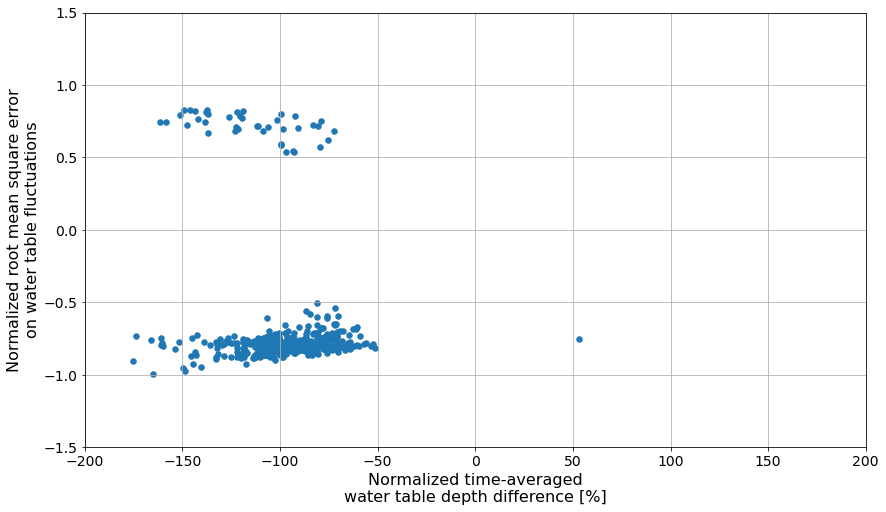

In [33]:
np.load('Average_transient_nRMSE.npy')
np.load('Normalized_meanwtd_difference.npy')

plt.rcParams['figure.figsize'] = [14, 8.0]
plt.figure()
plt.scatter(Normalized_meanwtd_difference, Average_transient_nRMSE, marker='o', s=30)
# If Normalized_meanwtd_difference is negative, simulated water table is too deep in average
# If Average_transient_nRMSE is positive, simulated seasonal amplitudes are too high in average
plt.xlabel('Normalized time-averaged\nwater table depth difference [%]', fontsize=16)
plt.ylabel('Normalized root mean square error\non water table fluctuations', fontsize=16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim((-200,200))
plt.ylim((-1.5,1.5))

In [32]:
Normalized_meanwtd_difference[Normalized_meanwtd_difference==0]=1000
Average_transient_nRMSE[Average_transient_nRMSE==0]=1000
Index=np.argsort((np.abs(Normalized_meanwtd_difference/100)+np.abs(Average_transient_nRMSE))*0.5)
bestvalue=np.sort((np.abs(Normalized_meanwtd_difference/100)+np.abs(Average_transient_nRMSE))*0.5)
print(Index)
print(bestvalue)
print(Normalized_meanwtd_difference[28])
print(Average_transient_nRMSE[28])

[ 76 242 118  60 139  98  54  72 161 110 145  39 165  84 177  33  68  49
  69 192  58 129  20 136  97 102 272  63  48 214 107 222 194  21  82 120
 142  70  17 221  40 134  61 130  67 153  37 211  74 210 364  29  41 116
  87 228 162  66 156   1  52 147 303  10   7 230  25 164 339 290  51  38
  96  94 261 140 148  77 123 184 340 251  42 183  36 127 225 217   2  99
  75  55 113 150 135 240 115 132 334  27 195  81 103 302 207 229  28 111
 236 189 213 279 274 219  35  78  31  93  47 178  44 155  64  43  19 105
 163 250 108 323 181 100 137 128 306 171 201 174 185   5 307 287 167 238
  71  16 215 152 241 363  91 283 318  65 234 131 151 333 112  12  11 269
 356  50 175 200 223 199 342 329 186 280 198 353 299 260 146 172  95 249
 308 282  57 119 288 169 246 206 325   6 263 196 243  46 305 281 124 297
  59 232 291 117 191 258 301 262 168 351   4 143 237 267 310 270 304 220
   8 173 256 350 218  56 366 331 180  88 259 355 271 346 179 354 188   3
 265 332 244 224  22  90  32  80  79  15 255 125 34